In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from poker_utils.hands import card_distance, normalize_hand
from poker_utils.constants import HANDS, DECK_DICT
from torch.utils.data import Dataset, DataLoader,WeightedRandomSampler
import matplotlib.pyplot as plt 
import seaborn as sns
from poker_utils.model import plot_train_loss
import torch.nn.functional as F
from sklearn.manifold import TSNE


In [2]:
class CardDataset(Dataset):
    def __init__(self, weight_cols=['card1_suit', 'card2_suit', 'card_dist']):
        card_to_id = {j:i for i,j in DECK_DICT.items()}
        self.data = pd.DataFrame(HANDS, columns=['card1','card2'])
        for i in range(1,3):
            self.data[f'card{i}_id'] = self.data[f'card{i}'].apply(lambda x: card_to_id[x])
            self.data[f'card{i}_rank'] = self.data[f'card{i}_id'] // 4
            self.data[f'card{i}_suit'] = self.data[f'card{i}_id'] % 4
        self.data['card_dist'] = self.data.apply(
            lambda x: card_distance(normalize_hand((x['card1'],x['card2']))), axis=1)
        
        self.class_weights = {
            'card1_rank': None, 
            'card1_suit': None,
            'card2_rank': None, 
            'card2_suit': None, 
            'card_dist': None
            }
        for key in self.class_weights.keys():
            counts = self.data[key].value_counts().to_numpy()
            total = counts.sum()
            class_weights = total / (len(counts) * counts)
            self.class_weights[key] = torch.tensor(class_weights, dtype=torch.float32)
            
        for col in weight_cols:
            weights = 1.0 / self.data[col].value_counts(normalize=True)
            self.data[f"{col}_weight"] = self.data[col].map(weights)
        self.data['sample_weight'] = self.data.filter(regex='weight').prod(axis=1)
        self.data['sample_weight'] = self.data['sample_weight'] / self.data['sample_weight'].sum()
        self.sample_weights = torch.tensor(self.data['sample_weight'].values, dtype=torch.float)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        card1 = row['card1_id']
        card2 = row['card2_id']
        card1_rank = row['card1_rank']
        card2_rank = row['card2_rank']
        card1_suit = row['card1_suit']
        card2_suit = row['card2_suit']
        card_dist = row['card_dist']
        return {
            'card1': torch.tensor(card1, dtype=torch.long),
            'card2': torch.tensor(card2, dtype=torch.long),
            'card1_rank': torch.tensor(card1_rank, dtype=torch.long),
            'card2_rank': torch.tensor(card2_rank, dtype=torch.long),
            'card1_suit': torch.tensor(card1_suit, dtype=torch.long),
            'card2_suit': torch.tensor(card2_suit, dtype=torch.long),
            'card_dist': torch.tensor(card_dist, dtype=torch.long),
        }
        

In [3]:
dataset = CardDataset(weight_cols=['card_dist'])
sampler = WeightedRandomSampler(dataset.sample_weights, 
                                num_samples=len(dataset.sample_weights), 
                                replacement=True)

dataloader = DataLoader(dataset, batch_size=128, sampler=sampler)

In [58]:
class CardEncoder(nn.Module):
    def __init__(self, card_dim=2):
        super().__init__()
        self.card_embedder = nn.Embedding(53, card_dim, padding_idx=52)
        self.shared_encoder = nn.Sequential(
            nn.BatchNorm1d(card_dim),
            nn.Linear(card_dim, card_dim),
            nn.ReLU(),
            nn.Linear(card_dim, card_dim),
            nn.Dropout(0.1),
            nn.ReLU()
            )
        self.rank_head = nn.Linear(card_dim, 13)
        self.suit_head = nn.Linear(card_dim, 4)
        self.card_dist_head = nn.Linear(card_dim*2, 12)
        
    def get_card_embedding(self, card_ids):
        raw_emb = self.card_embedder(card_ids)
        return self.shared_encoder(raw_emb)
    
    def forward(self, card1, card2):
        # get embeddings
        card1_emb = self.card_embedder(card1)
        card1_emb = self.shared_encoder(card1_emb)
        card2_emb = self.card_embedder(card2)
        card2_emb = self.shared_encoder(card2_emb)
        
        # rank prediction
        rank1_pred = self.rank_head(card1_emb)
        rank2_pred = self.rank_head(card2_emb)
        
        # suit prediction
        suit1_pred = self.suit_head(card1_emb)
        suit2_pred = self.suit_head(card2_emb)
        
        # distance prediction
        diff = torch.abs(card1_emb - card2_emb)
        prod = card1_emb * card2_emb
        x = torch.cat([diff, prod], dim=1)
        # x = torch.cat([card1_emb, card2_emb], dim=1)
        card_dist = self.card_dist_head(x)
        return {
            'pred_card1_rank': rank1_pred,
            'pred_card2_rank': rank2_pred,
            'pred_card1_suit': suit1_pred,
            'pred_card2_suit': suit2_pred,
            'pred_card_dist': card_dist
        }
        

In [59]:
def contrastive_loss(emb1, emb2, label, margin=1.0):
    dists = F.pairwise_distance(emb1, emb2)
    loss = (label.float() * dists.pow(2)) + ((1 - label.float()) * F.relu(margin - dists).pow(2))
    return loss.mean()


In [60]:
model = CardEncoder(card_dim=64)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [61]:
epochs = 400
contr_alpha = 0.1
dist_alpha = 4
cls_losses = []
contr_losses = []
accuracies = {
            'pred_card1_rank': [],
            'pred_card2_rank': [],
            'pred_card1_suit': [],
            'pred_card2_suit': [],
            'pred_card_dist': []
        }
for epoch in range(epochs):
    model.train()
    tot_loss = 0
    tot_contrastive_loss = 0
    correct = {
            'pred_card1_rank': 0, 'pred_card2_rank': 0,
            'pred_card1_suit': 0, 'pred_card2_suit': 0,'pred_card_dist': 0}
    for i, batch in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(batch['card1'], batch['card2'])
        cls_loss = 0
        contr_loss = 0
        for key, logits in output.items():
            if key != 'pred_card_dist':
                cls_loss += F.cross_entropy(
                    logits, 
                    batch[key.removeprefix("pred_")], 
                    weight=dataset.class_weights[key.removeprefix("pred_")])
            else:
                cls_loss += F.cross_entropy(
                    logits, 
                    batch[key.removeprefix("pred_")], 
                    weight=dataset.class_weights[key.removeprefix("pred_")]) * dist_alpha
                
            preds = logits.argmax(dim=1)
            correct[key] += (preds == batch[key.removeprefix("pred_")]).sum().item()
            
        emb1 = model.get_card_embedding(batch['card1'])
        emb2 = model.get_card_embedding(batch['card2'])
        for attr in ['rank', 'suit']:
            contrastive_labels = (batch[f'card1_{attr}'] == batch[f'card2_{attr}']).long()
            contr_loss += contrastive_loss(emb1, emb2, contrastive_labels)
        total = cls_loss + contr_alpha * contr_loss
        total.backward()
        optimizer.step()

        tot_loss += cls_loss.item()
        tot_contrastive_loss += contr_loss.item()
    scheduler.step()
        
    for key, num in correct.items():
        accuracies[key].append(num / 1326)
    cls_losses.append(tot_loss / len(dataloader))
    contr_losses.append(tot_contrastive_loss / len(dataloader))
        

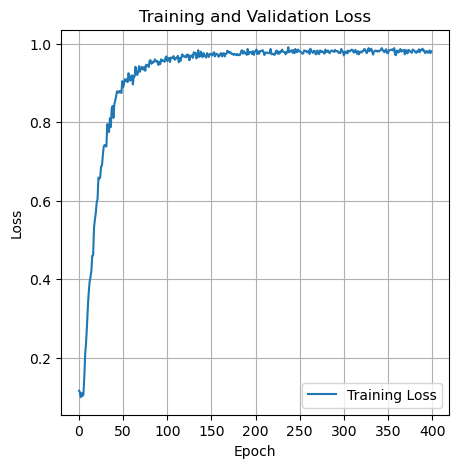

In [62]:
plot_train_loss(accuracies['pred_card_dist'])

In [63]:

testloader = DataLoader(dataset=dataset, batch_size=128, shuffle=False)
predictions = {}
model.eval()
with torch.no_grad():
    for i, batch in enumerate(testloader):
        output = model(batch['card1'],batch['card2'])
        for key, batch in output.items():
            if i==0:
                predictions[key] = batch
            else:
                predictions[key] = torch.cat([predictions[key], batch], dim=0)
    for key in predictions:
        predictions[key] = predictions[key].argmax(dim=1).numpy()
    embeddings = model.get_card_embedding(torch.arange(52))

In [64]:
prediction_df = pd.DataFrame.from_dict(predictions, orient='columns')
data = pd.concat([dataset.data, prediction_df], axis=1)

In [66]:
print(data[data['card1_rank'] != data['pred_card1_rank']].shape[0])
print(data[data['card2_rank'] != data['pred_card2_rank']].shape[0])
print(data[data['card1_suit'] != data['pred_card1_suit']].shape[0])
print(data[data['card2_suit'] != data['pred_card2_suit']].shape[0])
print(data[data['card_dist'] != data['pred_card_dist']].shape[0])

0
0
0
0
0


In [68]:
embeddings_norm = F.normalize(embeddings)

In [69]:
tsne = TSNE(n_components=2, perplexity=15, random_state=29)
embeddings_2d = tsne.fit_transform(embeddings_norm)

In [70]:
emb_data = pd.DataFrame(embeddings_2d, columns=['C1','C2'])
emb_data['card_id'] = np.arange(52)
emb_data[f'card_rank'] = emb_data[f'card_id'] // 4
emb_data[f'card_suit'] = emb_data[f'card_id'] % 4

<Axes: xlabel='C1', ylabel='C2'>

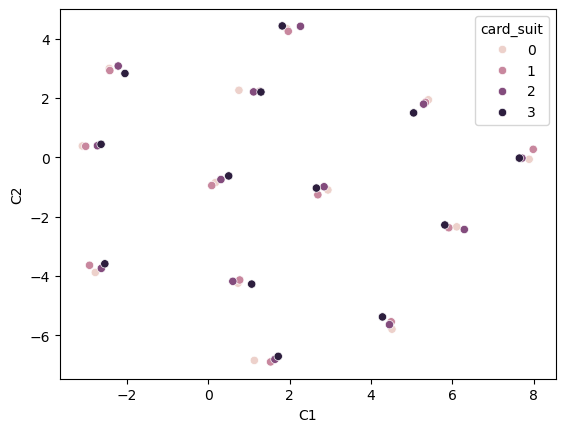

In [ ]:
sns.scatterplot(emb_data, x='C1',y='C2', hue='card_suit')

In [ ]:
# torch.save(embeddings, "embeddings/card_embeddings.pt")